In [34]:
import pandas as pd
import numpy as np
import arrow
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor

In [42]:
df = pd.read_csv('USvideos.csv')
df_10 = df[df['category_id'] == 10]

index = int(len(df_10)*0.8)
df_train =df_10[:index]
df_test = df_10[index:]

X_train = df_train[["likes"]].to_numpy()
Y_train = df_train["views"].to_numpy()
X_test = df_test[["likes"]].to_numpy()
Y_test = df_test["views"].to_numpy()

In [43]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [44]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("MSE: %.2f" % mse)
print("R2 Score: %.2f" % r2)



MSE: 160509780532214.59
R2 Score: 0.75


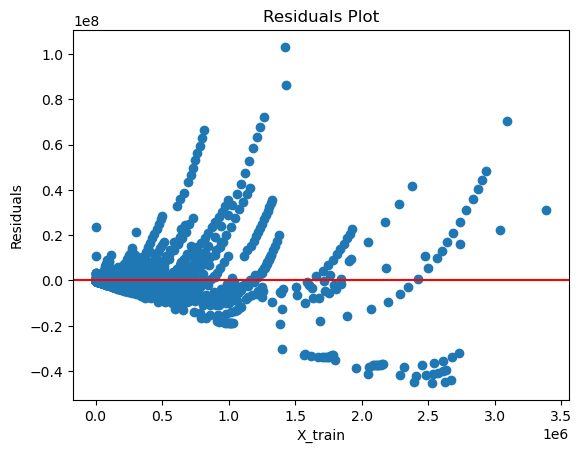

In [45]:
Y_train_pred = model.predict(X_train)

residuals = Y_train - Y_train_pred
studentized_residuals = residuals / np.sqrt(mean_squared_error(Y_train, Y_train_pred))
outliers = np.abs(studentized_residuals) > 2
plt.scatter(X_train, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('X_train')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [46]:
cook_distance = (residuals ** 2) / (model.coef_ ** 2 * X_train.var())
outliers_cooks = cook_distance > 4 / len(X_train[0])

print("Outliers based on studentized residuals:", np.where(outliers)[0])
print("Outliers based on Cook's distance:", np.where(outliers_cooks)[0])

outliers_indices = np.where(outliers)[0]


Outliers based on studentized residuals: [ 113  149  185  229  285  336  377  413  424  452  459  490  493  527
  568  604  635 1140 1176 1454 1468 1482 1496 1525 1555 1582 1609 2066
 2094 2132 2171 2209 2248 3127 3150 3172 3194 3217 3232 3255 3276 3301
 3328 3353 3379 3405 3425 3437 3454 3466 3485 3497 3515 3527 3544 3556
 3577 3607 3638 3667 3672 3703 3708 3735 3740 3765 3795 4052 4086 4134
 4140 4172 4178 4188 4201 4208 4214 4235 4242 4248 4269 4270 4276 4282
 4301 4302 4307 4313 4331 4332 4338 4344 4346 4366 4367 4373 4378 4399
 4400 4403 4406 4409 4423 4431 4432 4434 4454 4462 4463 4465 4487 4495
 4496 4499 4519 4527 4528 4532 4537 4551 4558 4559 4566 4572 4585 4598
 4604 4617 4633 4639 4652 4665 4671 4684 4702 4705 4733 4736 4766 4769
 4801 4803 4836 4839 4846 4863 4874 4877 4884 4904 4915 4918 4922 4942
 4953 4955 4956 4963 4986 5004 5027 5028 5046 5050 5069 5070 5085 5089
 5099 5108 5109 5113 5123 5132 5141 5154 5157 5161 5165 5169 5170]
Outliers based on Cook's distance: [ 149

In [49]:
cleaned_X = np.delete(X_train, outliers_indices, axis=0)
cleaned_y = np.delete(Y_train, outliers_indices, axis=0)

model.fit(cleaned_X, cleaned_y)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("new MSE: %.2f" % mse)
print("new R2 Score: %.2f" % r2)

new MSE: 164476741480761.81
new R2 Score: 0.74


In [50]:
outliers_indices_Cook = np.where(outliers_cooks)[0]

cleaned_X_Cook = np.delete(X_train, outliers_indices_Cook, axis=0)
cleaned_y_Cook = np.delete(Y_train, outliers_indices_Cook, axis=0)

model.fit(cleaned_X_Cook, cleaned_y_Cook)
Y_pred_cook = model.predict(X_test)
mse_Cook = mean_squared_error(Y_test, Y_pred_cook)
r2_Cook = r2_score(Y_test, Y_pred_cook)
print("new MSE: %.2f" % mse_Cook)
print("new R2 Score: %.2f" % r2_Cook)

new MSE: 160369426256215.56
new R2 Score: 0.75


In [51]:
all_outliers_indices = np.union1d(outliers_indices, outliers_indices_Cook)

df_10_cleaned = df_10.drop(df_10.index[all_outliers_indices])

df.update(df_10_cleaned)

df = df[~((df['category_id'] == 10) & (~df.index.isin(df_10_cleaned.index)))]

df.to_csv('USvideos_cleaned.csv', index=False)

In [52]:
def standardize_trending_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%y.%d.%m')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def standardize_publish_time(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

In [53]:
df_10_cleaned['trending_date'] = df_10_cleaned['trending_date'].apply(standardize_trending_date)
df_10_cleaned['publish_time'] = df_10_cleaned['publish_time'].apply(standardize_publish_time)

In [58]:
time_series_10 = df_10_cleaned.groupby(['trending_date']).size().reset_index(name = 'counts')
print(time_series_10)

    trending_date  counts
0      2017-11-14      45
1      2017-11-15      37
2      2017-11-16      29
3      2017-11-17      28
4      2017-11-18      33
..            ...     ...
200    2018-06-10      51
201    2018-06-11      51
202    2018-06-12      50
203    2018-06-13      51
204    2018-06-14      49

[205 rows x 2 columns]


In [59]:
iddf = pd.read_csv('US_category_id.csv')

category_dict = pd.Series(iddf.title.values, index=iddf.id).to_dict()

In [60]:
from statsmodels.tsa.arima.model import ARIMA
forecast_results = {}

In [66]:
category_data = time_series_10[:-20]

In [67]:
print(category_data)

               counts
trending_date        
2017-11-14         45
2017-11-15         37
2017-11-16         29
2017-11-17         28
2017-11-18         33
...               ...
2018-05-21         34
2018-05-22         35
2018-05-23         38
2018-05-24         39
2018-05-25         40

[185 rows x 1 columns]


d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

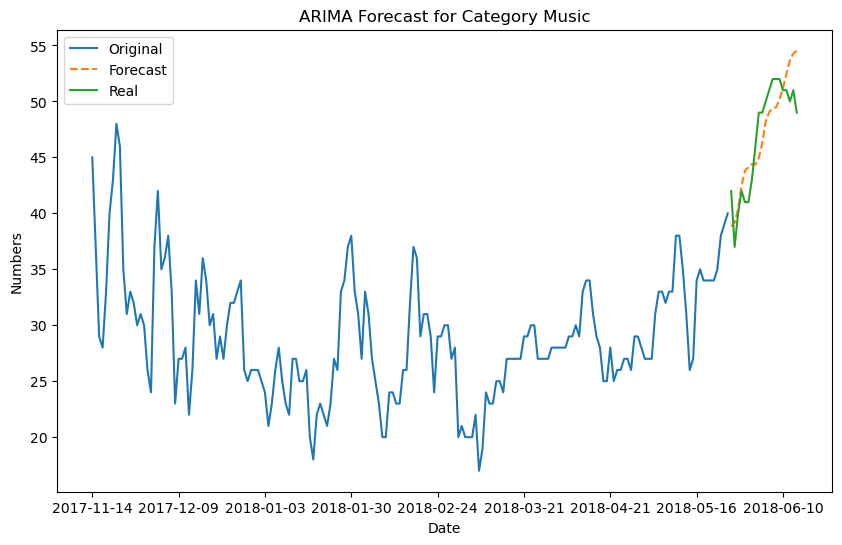

In [96]:
from matplotlib.ticker import MaxNLocator
category_data = time_series_10[:-20]
    

    
ts = category_data['counts']
original_ts = time_series_10['counts'][-20:]
model = ARIMA(ts, order=(12, 2, 0))
model_fit = model.fit()
    
forecast = model_fit.forecast(steps=20)
    
    
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.plot(original_ts, label='Real')
plt.title(f'ARIMA Forecast for Category {category_dict[10]}')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.show()